# How to create a  video story from text with Artificial Intelligence
> An introduction tutorial to create a simple application that will generate a video from a text with images generated with Artificial Intellingence.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/chart-preview.png

# Step 1 - Libraries Installation

The application that we will use will perform a summary of the text that you will introduce by sing the BART-Model and the generation of the Images will be produced by Dalle-Mini. 

- Dalle mini is a free, open-source AI that produces amazing images from text inputs.

- The BART Model with a language modeling head. Can be used for summarization. This model inherits from PreTrainedModel.

In [1]:
!nvidia-smi
!pip install min-dalle
!pip install gradio -q
!pip install transformers torch requests moviepy huggingface_hub opencv-python
!pip install moviepy
!pip install imageio-ffmpeg
!pip install imageio==2.4.1
!apt install imagemagick
!cat /etc/ImageMagick-6/policy.xml | sed 's/none/read,write/g'> /etc/ImageMagick-6/policy.xml
!pip install mutagen
!pip install gtts
#We reset the runtime
exit()

Thu Sep 15 08:49:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Step 2 - Importing Libraries

In [1]:
from moviepy.editor import *
from PIL import Image
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM,pipeline
import requests
import gradio as gr
import torch
import re
import os
import sys
from huggingface_hub import snapshot_download
import base64
import io
import cv2

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)4186112/45929032 bytes (9.1%)8331264/45929032 bytes (18.1%)12468224/45929032 bytes (27.1%)16596992/45929032 bytes (36.1%)20766720/45929032 bytes (45.2%)24698880/45929032 bytes (53.8%)28876800/45929032 bytes (62.9%)32899072/45929032 bytes (71.6%)36921344/45929032 bytes (80.4%)41263104/45929032 bytes (89.8%)45449216/45929032 bytes (99.0%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

# Step 3- Creation of the application

In this part we need to write the text that we want to create our video story

In [2]:
text ='Once, there was a girl called Ella who went to the supermarket to buy the ingredients to make a cake. Because today is her birthday and her friends come to her house and help her to prepare the cake.'

In [4]:
print(text)

Once, there was a girl called Ella who went to the supermarket to buy the ingredients to make a cake. Because today is her birthday and her friends come to her house and help her to prepare the cake.


and we need to load our summary AI program

In [3]:
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")
model = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-cnn-12-6")

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

In [13]:
tokenizer

PreTrainedTokenizerFast(name_or_path='sshleifer/distilbart-cnn-12-6', vocab_size=50265, model_max_len=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})

In [12]:
model

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((102

Now that have loaded our pretrained ML model to summayse our text we can get the summary

In [5]:
inputs = tokenizer(text, 
                  max_length=1024, 
                  truncation=True,
                  return_tensors="pt")
  
summary_ids = model.generate(inputs["input_ids"])
summary = tokenizer.batch_decode(summary_ids, 
                                skip_special_tokens=True, 
                                clean_up_tokenization_spaces=False)
plot = list(summary[0].split('.'))

  UserWarning,



In [16]:
text

'Once, there was a girl called Ella who went to the supermarket to buy the ingredients to make a cake. Because today is her birthday and her friends come to her house and help her to prepare the cake.'

In [15]:
plot

[' Ella went to the supermarket to buy the ingredients to make a cake ',
 ' Today is her birthday and her friends come to her house and help her to prepare the cake ',
 " Ella's friends help her prepare her birthday cake and help prepare it for her friends' birthday ",
 '']

Now we create the main program that generate the images

In [6]:
import argparse
import os
from PIL import Image
from min_dalle import MinDalle
import torch

def save_image(image: Image.Image, path: str):
    if os.path.isdir(path):
        path = os.path.join(path, 'generated.png')
    elif not path.endswith('.png'):
        path += '.png'
    print("saving image to", path)
    image.save(path)
    return image

def generate_image(
    is_mega: bool,
    text: str,
    seed: int,
    grid_size: int,
    top_k: int,
    image_path: str,
    models_root: str,
    fp16: bool,
):
    model = MinDalle(
        is_mega=is_mega, 
        models_root=models_root,
        is_reusable=False,
        is_verbose=True,
        dtype=torch.float16 if fp16 else torch.float32
    )

    image = model.generate_image(
        text, 
        seed, 
        grid_size, 
        top_k=top_k, 
        is_verbose=True
    )
    save_image(image, image_path)
    im = Image.open("generated.png")
    return im 

Let us generate the images from our summary text

 Ella went to the supermarket to buy the ingredients to make a cake 
using device cuda
downloading tokenizer params
intializing TextTokenizer
tokenizing text
['Ġella']
['Ġwent']
['Ġto']
['Ġthe']
['Ġsupermarket']
['Ġto']
['Ġbuy']
['Ġthe']
['Ġingredients']
['Ġto']
['Ġmake']
['Ġa']
['Ġcake']
15 text tokens [0, 16871, 8398, 123, 99, 12553, 123, 403, 99, 13241, 123, 1077, 58, 2354, 2]
downloading encoder params
initializing DalleBartEncoder
encoding text tokens
downloading decoder params
initializing DalleBartDecoder
downloading detokenizer params
initializing VQGanDetokenizer
detokenizing image
saving image to generated.png


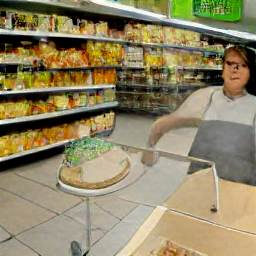

 Today is her birthday and her friends come to her house and help her to prepare the cake 
using device cuda
intializing TextTokenizer
tokenizing text
['Ġtoday']
['Ġis']
['Ġher']
['Ġbirthday']
['Ġand']
['Ġher']
['Ġfriends']
['Ġcome']
['Ġto']
['Ġher']
['Ġhouse']
['Ġand']
['Ġhelp']
['Ġher']
['Ġto']
['Ġprepare']
['Ġthe']
['Ġcake']
20 text tokens [0, 1535, 231, 447, 1249, 128, 447, 3103, 4118, 123, 447, 610, 128, 1980, 447, 123, 11147, 99, 2354, 2]
initializing DalleBartEncoder
encoding text tokens
initializing DalleBartDecoder
initializing VQGanDetokenizer
detokenizing image
saving image to generated.png


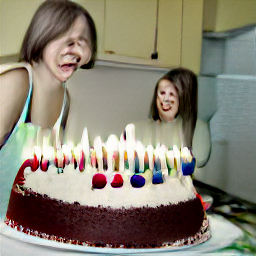

 Ella's friends help her prepare her birthday cake and help prepare it for her friends' birthday 
using device cuda
intializing TextTokenizer
tokenizing text
['Ġella', "'s"]
['Ġfriends']
['Ġhelp']
['Ġher']
['Ġprepare']
['Ġher']
['Ġbirthday']
['Ġcake']
['Ġand']
['Ġhelp']
['Ġprepare']
['Ġit']
['Ġfor']
['Ġher']
['Ġfriends', "'"]
['Ġbirthday']
20 text tokens [0, 16871, 168, 3103, 1980, 447, 11147, 447, 1249, 2354, 128, 1980, 11147, 353, 129, 447, 3103, 9, 1249, 2]
initializing DalleBartEncoder
encoding text tokens
initializing DalleBartDecoder
initializing VQGanDetokenizer
detokenizing image
saving image to generated.png


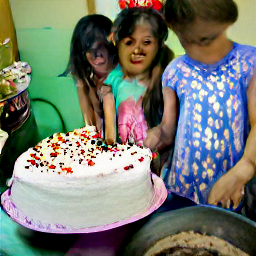

In [7]:
generated_images = []
for senten in plot[:-1]:
  print(senten)
  image=generate_image(
    is_mega='store_true',
    text=senten,
    seed=1,
    grid_size=1,
    top_k=256,
    image_path='generated',
    models_root='pretrained',
    fp16=256,)
  display(image)
  generated_images.append(image)

In [8]:
for senten in plot[:-1]:
  print(senten)

 Ella went to the supermarket to buy the ingredients to make a cake 
 Today is her birthday and her friends come to her house and help her to prepare the cake 
 Ella's friends help her prepare her birthday cake and help prepare it for her friends' birthday 


In [9]:
sentences =plot[:-1]
num_sentences=len(sentences)

In [10]:
assert len(generated_images) == len(sentences) , print('Something is wrong')

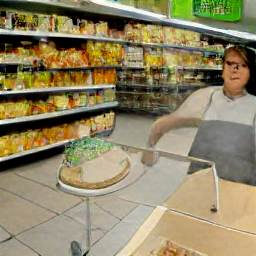

 Ella went to the supermarket to buy the ingredients to make a cake 


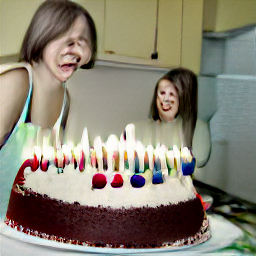

 Today is her birthday and her friends come to her house and help her to prepare the cake 


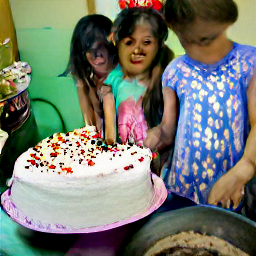

 Ella's friends help her prepare her birthday cake and help prepare it for her friends' birthday 


In [11]:
for k in range(len(generated_images)):
    display(generated_images[k])
    print(sentences[k])

# Step 4 - Creation of the subtitles
There are two ways to create the subtitles
- With Spacy
- WIth NLTK



By default, spaCy uses its dependency parser to do sentence segmentation, which requires loading a statistical model. The sentencizer is a rule-based sentence segmenter that you can use to define your own sentence segmentation rules without loading a model.

In [17]:
import spacy
nlp = spacy.load('en_core_web_sm') # or whatever model you have installed
raw_text = sentences[1]
doc = nlp(raw_text)
subtitles = [sent.text.strip() for sent in doc.sents]
subtitles

['Today is her birthday and her friends come to her house and help her to prepare the cake']

In [18]:
import spacy
nlp = spacy.load('en_core_web_sm') # or whatever model you have installed
c = 0
sub_names = []
for k in range(len(generated_images)): 
  raw_text = sentences[k]
  doc = nlp(raw_text)
  subtitles = [sent.text.strip() for sent in doc.sents]
  sub_names.append(subtitles)
  print(raw_text,subtitles, len(subtitles))

 Ella went to the supermarket to buy the ingredients to make a cake  ['Ella went to the supermarket to buy the ingredients to make a cake'] 1
 Today is her birthday and her friends come to her house and help her to prepare the cake  ['Today is her birthday and her friends come to her house and help her to prepare the cake'] 1
 Ella's friends help her prepare her birthday cake and help prepare it for her friends' birthday  ['', "Ella's friends help her prepare her birthday cake and help prepare it for her friends' birthday"] 2


NLTK Tokenizer Package Tokenizers divide strings into lists of substrings. For example, If we want to Return a sentence-tokenized copy of text, using NLTK’s recommended sentence tokenizer

In [22]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
from nltk import tokenize
subtitles=tokenize.sent_tokenize(sentences[1], language='english')
print(sentences[1],subtitles)

 Today is her birthday and her friends come to her house and help her to prepare the cake  [' Today is her birthday and her friends come to her house and help her to prepare the cake']


We can generate our list of subtitles

In [24]:
from nltk import tokenize
c = 0
sub_names = []
for k in range(len(generated_images)): 
  subtitles=tokenize.sent_tokenize(sentences[k])
  sub_names.append(subtitles)
  print(sentences[k],subtitles, len(subtitles))

 Ella went to the supermarket to buy the ingredients to make a cake  [' Ella went to the supermarket to buy the ingredients to make a cake'] 1
 Today is her birthday and her friends come to her house and help her to prepare the cake  [' Today is her birthday and her friends come to her house and help her to prepare the cake'] 1
 Ella's friends help her prepare her birthday cake and help prepare it for her friends' birthday  [" Ella's friends help her prepare her birthday cake and help prepare it for her friends' birthday"] 1


In [25]:
sub_names[2]

[" Ella's friends help her prepare her birthday cake and help prepare it for her friends' birthday"]

# Step 5 - Adding Subtitles to the Images

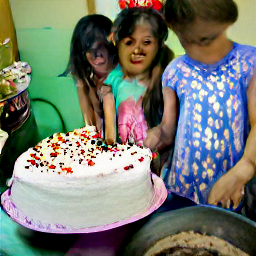

 Ella's friends help her prepare her birthday cake and help prepare it for her friends' birthday


In [26]:
from PIL import ImageDraw
# copying image to another image object
image = generated_images[2].copy()
add_subtitle=sub_names[2][0]
display(image)
print(add_subtitle)

In [27]:
ImageDraw.Draw(
    image  # Image
).text(
    (0, 0),  # Coordinates
    add_subtitle,  # Text
    (0, 0, 0)  # Color
)

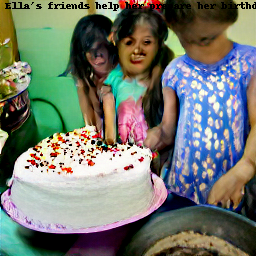

In [28]:
display(image)

We need a program to determine the size of text, a simple alternative can be 

In [29]:
!ls  /usr/share/fonts/truetype/liberation

LiberationMono-BoldItalic.ttf	     LiberationSansNarrow-Bold.ttf
LiberationMono-Bold.ttf		     LiberationSansNarrow-Italic.ttf
LiberationMono-Italic.ttf	     LiberationSansNarrow-Regular.ttf
LiberationMono-Regular.ttf	     LiberationSans-Regular.ttf
LiberationSans-BoldItalic.ttf	     LiberationSerif-BoldItalic.ttf
LiberationSans-Bold.ttf		     LiberationSerif-Bold.ttf
LiberationSans-Italic.ttf	     LiberationSerif-Italic.ttf
LiberationSansNarrow-BoldItalic.ttf  LiberationSerif-Regular.ttf


(256, 256)
(256, 256)
final font size 5


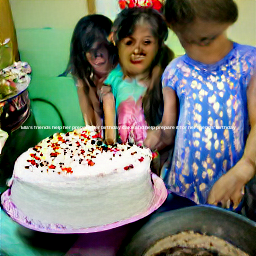

In [30]:

from PIL import ImageFont, ImageDraw, Image
#image = Image.open('test.jpg')
image = generated_images[2].copy()
draw = ImageDraw.Draw(image)
txt = sub_names[2][0]
fontsize = 1  # starting font size
W, H = image.size
# portion of image width you want text width to be
blank = Image.new('RGB',(256, 256))

#font = ImageFont.truetype("KeepCalm-Medium.ttf", fontsize)
path_font ="/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf"
# use a truetype font
#font = ImageFont.truetype("arial.ttf", fontsize)
font = ImageFont.truetype(path_font, fontsize)
print(image.size)
print(blank.size)
while (font.getsize(txt)[0] < blank.size[0]) and (font.getsize(txt)[1] < blank.size[1]):
    # iterate until the text size is just larger than the criteria
    fontsize += 1
    font = ImageFont.truetype(path_font, fontsize)
    # optionally de-increment to be sure it is less than criteria
fontsize -= 1
font = ImageFont.truetype(path_font, fontsize)
w, h = draw.textsize(txt, font=font)
print('final font size',fontsize)
draw.text(((W-w)/2,(H-h)/2), txt, font=font, fill="white") # put the text on the image
display(image)

However wee need resize the text into two lines

In [31]:
from PIL import Image, ImageDraw, ImageFont
import textwrap

def draw_multiple_line_text(image, text, font, text_color, text_start_height):
    '''
    From unutbu on [python PIL draw multiline text on image](https://stackoverflow.com/a/7698300/395857)
    '''
    draw = ImageDraw.Draw(image)
    image_width, image_height = image.size
    y_text = text_start_height
    lines = textwrap.wrap(text, width=40)
    for line in lines:
        line_width, line_height = font.getsize(line)
        draw.text(((image_width - line_width) / 2, y_text), 
                  line, font=font, fill=text_color)
        y_text += line_height

In [32]:
def add_text_to_img(text1,image_input):
    '''
    Testing draw_multiple_line_text
    '''
    #image_width
    #image = Image.new('RGB', (800, 600), color = (0, 0, 0))
    image =image_input
    fontsize = 13  # starting font size
    path_font="/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf"
    font = ImageFont.truetype(path_font, fontsize)
    #text1 = "I try to add text at the bottom of image and actually I've done it, but in case of my text is longer then image width it is cut from both sides, to simplify I would like text to be in multiple lines if it is longer than image width."
    #text2 = "You could use textwrap.wrap to break text into a list of strings, each at most width characters long"
    text_color = (255,255,0)
    text_start_height = 200
    draw_multiple_line_text(image, text1, font, text_color, text_start_height)
    #draw_multiple_line_text(image, text2, font, text_color, 400)
    #image.save('pil_text.png')
    return image
    #display(image)

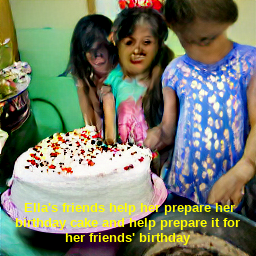

 Ella's friends help her prepare her birthday cake and help prepare it for her friends' birthday


In [33]:
image = generated_images[2].copy()
add_subtitle=sub_names[2][0]
result=add_text_to_img(add_subtitle,image)
display(result)
print(add_subtitle)

 text size auto adjust to an image with PIL

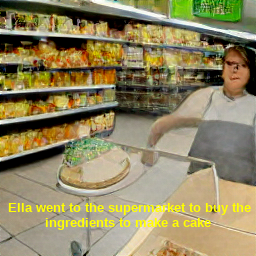

 Ella went to the supermarket to buy the ingredients to make a cake 1


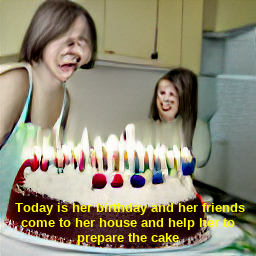

 Today is her birthday and her friends come to her house and help her to prepare the cake 1


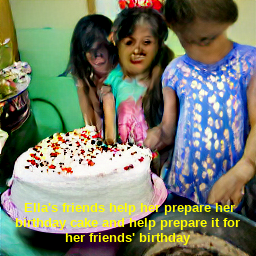

 Ella's friends help her prepare her birthday cake and help prepare it for her friends' birthday 1


In [34]:
generated_images_sub = []
for k in range(len(generated_images)): 
  image = generated_images[k].copy()
  text_to_add=sub_names[k][0]
  result=add_text_to_img(text_to_add,image)
  generated_images_sub.append(result)
  display(result)
  print(text_to_add, len(sub_names[k]))

# Step 5.1 - Creation of the Video

In [35]:
c = 0
file_names = []
for img in generated_images_sub:
  f_name = 'img_'+str(c)+'.jpg'
  file_names.append(f_name)
  img = img.save(f_name)
  c+=1
print(file_names)
clips = [ImageClip(m).set_duration(3)
        for m in file_names]

concat_clip = concatenate_videoclips(clips, method="compose")
concat_clip.write_videofile("result.mp4", fps=24)

['img_0.jpg', 'img_1.jpg', 'img_2.jpg']
[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 216/217 [00:00<00:00, 346.86it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



# Step 6 - Creation of the Video

In [36]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = "result.mp4"

# Compressed video path
compressed_path = "result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# Step  7 - Creation of audio 

In [37]:
!pip install gTTS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
# Import the required module for text
# to speech conversion
from gtts import gTTS
from IPython.display import Audio
from IPython.display import display



In [39]:
!pip install mutagen

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
# The text that you want to convert to audio
mytext = sub_names[1][0]
# Language in which you want to convert
language = 'en'
# Passing the text and language to the engine,
# here we have marked slow=False. Which tells
# the module that the converted audio should
# have a high speed
myobj = gTTS(text=mytext, lang=language, slow=False)
# Saving the converted audio in a mp3 file named
sound_file="audio.mp3"
myobj.save(sound_file)

In [41]:
from mutagen.mp3 import MP3
audio = MP3("audio.mp3")
print(audio.info.length)

6.36


In [42]:
wn = Audio(sound_file, autoplay=True) ##
display(wn)##

In [43]:
from mutagen.mp3 import MP3
c = 0
mp3_names = []
mp3_lengths = []
for k in range(len(generated_images)):
    text_to_add=sub_names[k][0]
    print(text_to_add)
    f_name = 'audio_'+str(c)+'.mp3'
    mp3_names.append(f_name)
    # The text that you want to convert to audio
    mytext = text_to_add
    # Language in which you want to convert
    language = 'en'
    # Passing the text and language to the engine,
    # here we have marked slow=False. Which tells
    # the module that the converted audio should
    # have a high speed
    myobj = gTTS(text=mytext, lang=language, slow=False)
    # Saving the converted audio in a mp3 file named
    sound_file=f_name
    myobj.save(sound_file)
    audio = MP3(sound_file)
    duration=audio.info.length
    mp3_lengths.append(duration)
    print(audio.info.length)
    c+=1
print(mp3_names)
print(mp3_lengths)

 Ella went to the supermarket to buy the ingredients to make a cake
5.04
 Today is her birthday and her friends come to her house and help her to prepare the cake
6.336
 Ella's friends help her prepare her birthday cake and help prepare it for her friends' birthday
6.624
['audio_0.mp3', 'audio_1.mp3', 'audio_2.mp3']
[5.04, 6.336, 6.624]


In [44]:
wn = Audio(mp3_names[0], autoplay=True) ##
display(wn)##

# Step 8 - Merge audio files

In [2]:
!zip archive.zip *.mp* *.jpg *.png

  adding: audio_0.mp3 (deflated 5%)
  adding: audio_1.mp3 (deflated 6%)
  adding: audio_2.mp3 (deflated 5%)
  adding: audio.mp3 (deflated 5%)
  adding: result_compressed.mp4 (deflated 7%)
  adding: result_compressed_new.mp4 (deflated 15%)
  adding: result_final_compressed.mp4 (deflated 10%)
  adding: result_final.mp4 (deflated 16%)
  adding: result.mp3 (deflated 10%)
  adding: result.mp4 (deflated 7%)
  adding: result_new.mp4 (deflated 15%)
  adding: __temp__.mp4 (deflated 19%)
  adding: img_0.jpg (deflated 1%)
  adding: img_1.jpg (deflated 1%)
  adding: img_2.jpg (deflated 1%)
  adding: generated.png (deflated 0%)


In [45]:
from pydub import AudioSegment
from os import getcwd
import glob

In [46]:
cwd = (getcwd()).replace(chr(92), '/')
#export_path = f'{cwd}/result.mp3'
export_path ='result.mp3'

In [47]:
MP3_FILES = glob.glob(pathname=f'{cwd}/*.mp3', recursive=True)

In [48]:
mp3_names

['audio_0.mp3', 'audio_1.mp3', 'audio_2.mp3']

In [49]:
silence = AudioSegment.silent(duration=500)
full_audio = AudioSegment.empty()    # this will accumulate the entire mp3 audios

In [50]:
for n, mp3_file in enumerate(mp3_names):
    mp3_file = mp3_file.replace(chr(92), '/')
    print(n, mp3_file)

    # Load the current mp3 into `audio_segment`
    audio_segment = AudioSegment.from_mp3(mp3_file)

    # Just accumulate the new `audio_segment` + `silence`
    full_audio += audio_segment + silence
    print('Merging ', n)

# The loop will exit once all files in the list have been used
# Then export    
full_audio.export(export_path, format='mp3')
print('\ndone!')

0 audio_0.mp3
Merging  0
1 audio_1.mp3
Merging  1
2 audio_2.mp3
Merging  2

done!


In [51]:
wn = Audio(export_path, autoplay=True) ##
display(wn)##

# Step 9 - Creation of the video with adjusted times of the sound


In [52]:
c = 0
file_names = []
for img in generated_images_sub:
  f_name = 'img_'+str(c)+'.jpg'
  file_names.append(f_name)
  img = img.save(f_name)
  c+=1
print(file_names)
clips=[]
d=0
for m in file_names:
  duration=mp3_lengths[d]
  print(d,duration)
  clips.append(ImageClip(m).set_duration(duration+0.5))
  d+=1
concat_clip = concatenate_videoclips(clips, method="compose")
concat_clip.write_videofile("result_new.mp4", fps=24)

['img_0.jpg', 'img_1.jpg', 'img_2.jpg']
0 5.04
1 6.336
2 6.624
[MoviePy] >>>> Building video result_new.mp4
[MoviePy] Writing video result_new.mp4


100%|█████████▉| 468/469 [00:00<00:00, 552.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_new.mp4 



In [53]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = "result_new.mp4"

# Compressed video path
compressed_path = "result_compressed_new.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# Step 10 - Merge Video + Audio


In [54]:
movie_name = 'result_new.mp4'
export_path='result.mp3'
movie_final= 'result_final.mp4'

In [55]:
# Import everything needed to edit video clips
from moviepy.editor import *
# loading video dsa gfg intro video
clip = VideoFileClip(movie_name)  
# getting duration of the video
duration = clip.duration
# printing duration
print("Duration : " + str(duration))
# showing final clip
clip.ipython_display()

Duration : 19.5


100%|█████████▉| 468/469 [00:00<00:00, 997.81it/s] 


In [56]:
def combine_audio(vidname, audname, outname, fps=60): 
    import moviepy.editor as mpe
    my_clip = mpe.VideoFileClip(vidname)
    audio_background = mpe.AudioFileClip(audname)
    final_clip = my_clip.set_audio(audio_background)
    final_clip.write_videofile(outname,fps=fps)


In [57]:
combine_audio(movie_name, export_path, movie_final) # i create a new file

[MoviePy] >>>> Building video result_final.mp4
[MoviePy] Writing audio in result_finalTEMP_MPY_wvf_snd.mp3


100%|██████████| 432/432 [00:00<00:00, 1072.43it/s]

[MoviePy] Done.
[MoviePy] Writing video result_final.mp4



100%|█████████▉| 1170/1171 [00:01<00:00, 645.62it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: result_final.mp4 



In [58]:
from IPython.display import HTML
from base64 import b64encode
import os
def compress_video(input_video):
    # Input video path
    save_path = input_video
    # Compressed video path
    compressed_path = save_path .replace(".mp4", "_compressed.mp4")
    print(compressed_path)
    os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")
    # Show video
    mp4 = open(compressed_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

In [59]:
compress_video("result_final.mp4")

result_final_compressed.mp4


In [60]:
# Show video
mp4 = open('result_final.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Great!, now the next step is the creation of the Huggin Face enviroment.

# Video Story Creator - Full single code

In [61]:
# Step 1 - Libraries Installation
!nvidia-smi
!pip install min-dalle
!pip install gradio -q
!pip install transformers torch requests moviepy huggingface_hub opencv-python
!pip install moviepy
!pip install imageio-ffmpeg
!pip install imageio==2.4.1
!apt install imagemagick
!cat /etc/ImageMagick-6/policy.xml | sed 's/none/read,write/g'> /etc/ImageMagick-6/policy.xml
!pip install gTTS
!pip install mutagen
#We reset the runtime
exit()

Thu Sep 15 09:40:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    30W /  70W |   1892MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Step 2 - Importing Libraries
from moviepy.editor import *
from PIL import Image
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM,pipeline
import requests
import gradio as gr
import torch
import re
import os
import sys
from huggingface_hub import snapshot_download
import base64
import io
import cv2
import argparse
import os
from PIL import Image
from min_dalle import MinDalle
import torch
from PIL import Image, ImageDraw, ImageFont
import textwrap
from mutagen.mp3 import MP3
# Import the required module for text
# to speech conversion
from gtts import gTTS
from IPython.display import Audio
from IPython.display import display
from pydub import AudioSegment
from os import getcwd
import glob
import nltk
from IPython.display import HTML
from base64 import b64encode
nltk.download('punkt')
# Libraries
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")
model = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-cnn-12-6")

# Step 3- Creation of the application
text ='Once, there was a girl called Laura who went to the supermarket to buy the ingredients to make a cake. Because today is her birthday and her friends come to her house and help her to prepare the cake.'
inputs = tokenizer(text, 
                  max_length=1024, 
                  truncation=True,
                  return_tensors="pt")
  
summary_ids = model.generate(inputs["input_ids"])
summary = tokenizer.batch_decode(summary_ids, 
                                skip_special_tokens=True, 
                                clean_up_tokenization_spaces=False)
plot = list(summary[0].split('.'))
def save_image(image: Image.Image, path: str):
    if os.path.isdir(path):
        path = os.path.join(path, 'generated.png')
    elif not path.endswith('.png'):
        path += '.png'
    print("saving image to", path)
    image.save(path)
    return image
def generate_image(
    is_mega: bool,
    text: str,
    seed: int,
    grid_size: int,
    top_k: int,
    image_path: str,
    models_root: str,
    fp16: bool,
):
    model = MinDalle(
        is_mega=is_mega, 
        models_root=models_root,
        is_reusable=False,
        is_verbose=True,
        dtype=torch.float16 if fp16 else torch.float32
    )

    image = model.generate_image(
        text, 
        seed, 
        grid_size, 
        top_k=top_k, 
        is_verbose=True
    )
    #save_image(image, image_path)
    #image = Image.open("generated.png")
    return image 

#Let us generate the images from our summary text
generated_images = []
for senten in plot[:-1]:
  #print(senten)
  image=generate_image(
    is_mega='store_true',
    text=senten,
    seed=1,
    grid_size=1,
    top_k=256,
    image_path='generated',
    models_root='pretrained',
    fp16=256,)
  #display(image)
  generated_images.append(image)

# Step 4- Creation of the subtitles
sentences =plot[:-1]
num_sentences=len(sentences)
assert len(generated_images) == len(sentences) , print('Something is wrong')
#We can generate our list of subtitles
from nltk import tokenize
c = 0
sub_names = []
for k in range(len(generated_images)): 
  subtitles=tokenize.sent_tokenize(sentences[k])
  sub_names.append(subtitles)
  #print(subtitles, len(subtitles))
  #!ls  /usr/share/fonts/truetype/liberation
# Step 5- Adding Subtitles to the Images
def draw_multiple_line_text(image, text, font, text_color, text_start_height):
    draw = ImageDraw.Draw(image)
    image_width, image_height = image.size
    y_text = text_start_height
    lines = textwrap.wrap(text, width=40)
    for line in lines:
        line_width, line_height = font.getsize(line)
        draw.text(((image_width - line_width) / 2, y_text), 
                  line, font=font, fill=text_color)
        y_text += line_height

def add_text_to_img(text1,image_input):
    '''
    Testing draw_multiple_line_text
    '''
    image =image_input
    fontsize = 13  # starting font size
    path_font="/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf"
    font = ImageFont.truetype(path_font, fontsize)
    text_color = (255,255,0)
    text_start_height = 200
    draw_multiple_line_text(image, text1, font, text_color, text_start_height)
    return image

# Testing
#for k in range(len(generated_images)):
#    display(generated_images[k])
#    print(sentences[k])

generated_images_sub = []
for k in range(len(generated_images)): 
  imagenes = generated_images[k].copy()
  text_to_add=sub_names[k][0]
  result=add_text_to_img(text_to_add,imagenes)
  generated_images_sub.append(result)
  #display(result)
  #print(text_to_add, len(sub_names[k]))


# Step  7 - Creation of audio 
c = 0
mp3_names = []
mp3_lengths = []
for k in range(len(generated_images)):
    text_to_add=sub_names[k][0]
    print(text_to_add)
    f_name = 'audio_'+str(c)+'.mp3'
    mp3_names.append(f_name)
    # The text that you want to convert to audio
    mytext = text_to_add
    # Language in which you want to convert
    language = 'en'
    # Passing the text and language to the engine,
    # here we have marked slow=False. Which tells
    # the module that the converted audio should
    # have a high speed
    myobj = gTTS(text=mytext, lang=language, slow=False)
    # Saving the converted audio in a mp3 file named
    sound_file=f_name
    myobj.save(sound_file)
    audio = MP3(sound_file)
    duration=audio.info.length
    mp3_lengths.append(duration)
    print(audio.info.length)
    c+=1
#print(mp3_names)
#print(mp3_lengths)

# Step 8 - Merge audio files
cwd = (getcwd()).replace(chr(92), '/')
#export_path = f'{cwd}/result.mp3'
export_path ='result.mp3'
MP3_FILES = glob.glob(pathname=f'{cwd}/*.mp3', recursive=True)
silence = AudioSegment.silent(duration=500)
full_audio = AudioSegment.empty()    # this will accumulate the entire mp3 audios
for n, mp3_file in enumerate(mp3_names):
    mp3_file = mp3_file.replace(chr(92), '/')
    print(n, mp3_file)

    # Load the current mp3 into `audio_segment`
    audio_segment = AudioSegment.from_mp3(mp3_file)

    # Just accumulate the new `audio_segment` + `silence`
    full_audio += audio_segment + silence
    print('Merging ', n)

# The loop will exit once all files in the list have been used
# Then export    
full_audio.export(export_path, format='mp3')
print('\ndone!')

# Step 9 - Creation of the video with adjusted times of the sound
c = 0
file_names = []
for img in generated_images_sub:
  f_name = 'img_'+str(c)+'.jpg'
  file_names.append(f_name)
  img = img.save(f_name)
  c+=1
print(file_names)
clips=[]
d=0
for m in file_names:
  duration=mp3_lengths[d]
  print(d,duration)
  clips.append(ImageClip(m).set_duration(duration+0.5))
  d+=1
concat_clip = concatenate_videoclips(clips, method="compose")
concat_clip.write_videofile("result_new.mp4", fps=24)

# Step 10 - Merge Video + Audio
movie_name = 'result_new.mp4'
export_path='result.mp3'
movie_final= 'result_final.mp4'

def combine_audio(vidname, audname, outname, fps=60): 
    import moviepy.editor as mpe
    my_clip = mpe.VideoFileClip(vidname)
    audio_background = mpe.AudioFileClip(audname)
    final_clip = my_clip.set_audio(audio_background)
    final_clip.write_videofile(outname,fps=fps)

combine_audio(movie_name, export_path, movie_final) # i create a new file

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2703360/45929032 bytes (5.9%)4751360/45929032 bytes (10.3%)7266304/45929032 bytes (15.8%)8609792/45929032 bytes (18.7%)10608640/45929032 bytes (23.1%)12509184/45929032 bytes (27.2%)14745600/45929032 bytes (32.1%)17154048/45929032 bytes (37.3%)19456000/45929032 bytes (42.4%)22216704/45929032 bytes (48.4%)24281088/45929032 bytes (52.9%)26697728/45929032 bytes (58.1%)2

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


  UserWarning,



using device cuda
downloading tokenizer params
intializing TextTokenizer
tokenizing text
['Ġonce', ',']
['Ġlaura']
['Ġwent']
['Ġto']
['Ġthe']
['Ġsupermarket']
['Ġto']
['Ġbuy']
['Ġthe']
['Ġingredients']
['Ġto']
['Ġmake']
['Ġa']
['Ġcake']
17 text tokens [0, 6619, 11, 7309, 8398, 123, 99, 12553, 123, 403, 99, 13241, 123, 1077, 58, 2354, 2]
downloading encoder params
initializing DalleBartEncoder
encoding text tokens
downloading decoder params
initializing DalleBartDecoder
downloading detokenizer params
initializing VQGanDetokenizer
detokenizing image
using device cuda
intializing TextTokenizer
tokenizing text
['Ġher']
['Ġfriends']
['Ġcome']
['Ġto']
['Ġher']
['Ġhouse']
['Ġand']
['Ġhelp']
['Ġher']
['Ġto']
['Ġprepare']
['Ġthe']
['Ġcake']
15 text tokens [0, 447, 3103, 4118, 123, 447, 610, 128, 1980, 447, 123, 11147, 99, 2354, 2]
initializing DalleBartEncoder
encoding text tokens
initializing DalleBartDecoder
initializing VQGanDetokenizer
detokenizing image
using device cuda
intializing TextTo

100%|██████████| 565/565 [00:01<00:00, 416.79it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: result_new.mp4 



[MoviePy] >>>> Building video result_final.mp4
[MoviePy] Writing audio in result_finalTEMP_MPY_wvf_snd.mp3


100%|██████████| 521/521 [00:00<00:00, 970.26it/s]

[MoviePy] Done.
[MoviePy] Writing video result_final.mp4



100%|██████████| 1413/1413 [00:02<00:00, 616.09it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: result_final.mp4 



In [ ]:
from IPython.display import HTML
from base64 import b64encode
# Show video
mp4 = open('result_final.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)